In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
import time

# Import the MFI library 
import MFI_lib2D as lib2
import MFI_class2D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_temp/convergence_analysis2pot1/"): print("\nThe data folder \"_data_temp/convergence_analysis2pot1/\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_temp/convergence_analysis2pot1/"); 
    path_data = path_notebook + "/_data_temp/convergence_analysis2pot1/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class2D

The data folder "_data_temp/convergence_analysis2pot1/" does not exist. Creating new folder.
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_temp/convergence_analysis2pot1/


### Define Potential and default parameters

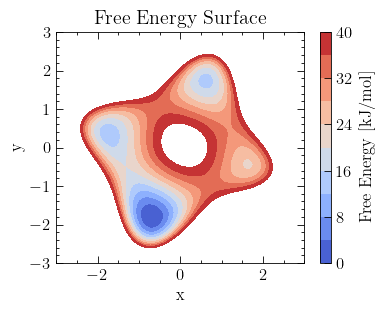

In [7]:
# Define the grid, the potential, the string of the potential and the FES cutoff
grid = np.linspace(-3, 3, 100); 
X, Y = np.meshgrid(grid, grid)
pot1 = 3.9*X**4 + 3.9*Y**4 - 19.2*X**2 - 19.2*Y**2 + 5.7*X**3*Y - 5.7*X*Y**3 + 12*X**2*Y**2 - 6*X*Y + 2.7*Y + 3.6*X
dpot1_dy, dpot1_dx = np.gradient(pot1, grid, grid)
pot1 = pot1 - np.min(pot1)
pot1_string = "3.9*x^4+3.9*y^4-19.2*x^2-19.2*y^2+5.7*x^3*y-5.7*x*y^3+12*x^2*y^2-6*x*y+2.7*y+3.6*x"
plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x,p.y FUNC=({pot1_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
FES_cutoff = 40

# Define plumed grid
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, [-4,-4], [4,4])

# plot the free energy surface
plt.contourf(X, Y, pot1, levels=np.linspace(0, FES_cutoff, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Free Energy Surface"); plt.show()

# Stimulation path
path_invernizzi = path_data + "Invernizzi_Potential/"

In [12]:
# default parameters for the MFI class
default_params = {  "X":X, "Y":Y, "Z":pot1, "bw":[0.1, 0.1], "dZ_dX":dpot1_dx, "dZ_dY":dpot1_dy,
                    "System":"Langevin", "plumed_dat_text":plumed_dat_text, "plX":plX, "plY":plY, "simulation_steps":1_500_000, 
                    "position_pace":20, "n_pos_per_window":10, "metad_pace":200, 
                    "metad_width":[0.1, 0.1], "metad_height":2, "biasfactor":20,
                    "Bias_sf":1, "gaus_filter_sigma":None,
                    "len_error_list":200,
                    "FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":None, "record_forces_e":True, 
                    "simulation_folder_path": path_invernizzi, "print_info": False}

### Run Long simulation for reference

Time taken for Long simulation: 25.4584 sec
Final Error: Aofe = 1.1703, AAD = 1.1010
MIN1 = 48.5843, MIN2 = 51.7709


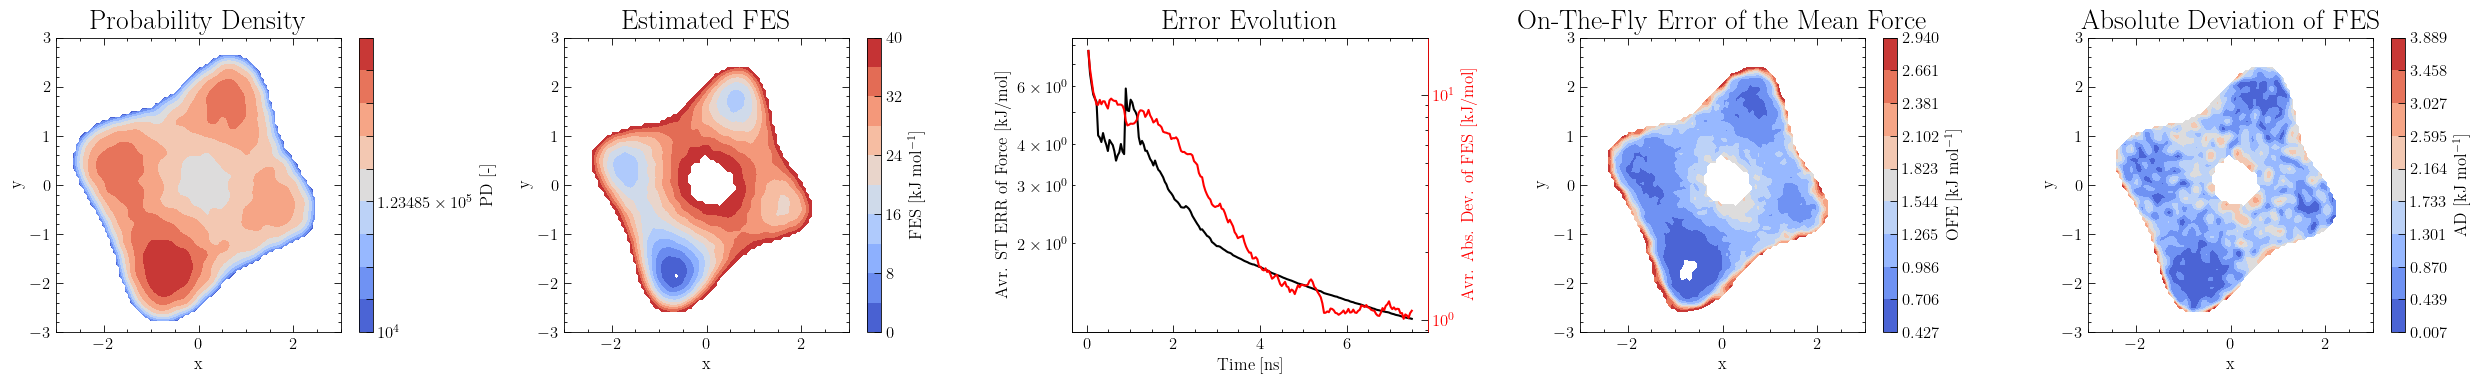

In [13]:
new_params = {**default_params}
new_params.update({"ID":"_long"})

start_long = time.time()
MFI_long = MFI_class2D.MFI2D(**new_params)
MFI_long.run_simulation()
MFI_long.analyse_data()
finish_long = time.time()

print(f"Time taken for Long simulation: {finish_long - start_long:.4f} sec")
print(F"Final Error: Aofe = {MFI_long.Aofe:.4f}, AAD = {MFI_long.AAD:.4f}")
print(f"MIN1 = {np.min(MFI_long.FES + MFI_long.Bias):.4f}, MIN2 = {np.min(pot1 + MFI_long.Bias):.4f}")

MFI_long.plot_res()
t_long, v_long, aofe_long, aad_long = MFI_long.Avr_Error_list[:,0], MFI_long.Avr_Error_list[:,1], MFI_long.Avr_Error_list[:,2], MFI_long.Avr_Error_list[:, MFI_long.aad_index]


### Exploration simulation

Time taken for Expl. simulation: 1.6854 sec
Final Error: Aofe = 7.7116, AAD = 3.3443
MIN(FES+Bias) = 38.5454, MIN(Z+Bias) = 30.0731


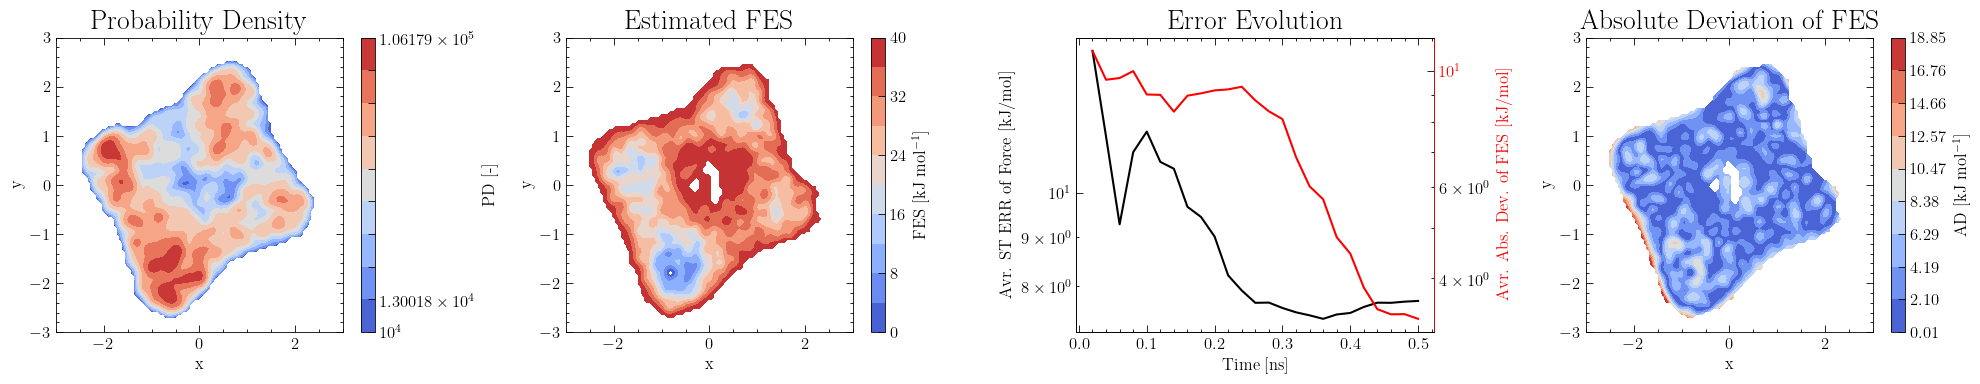

ready to show


In [14]:
new_params = {**default_params}
new_params.update({"ID":"_expl", "metad_height":10, "biasfactor":200})
new_params.update({"simulation_steps":100_000, "len_error_list":25})#, "n_pos":10_000})

start_expl = time.time()
MFI_expl = MFI_class2D.MFI2D(**new_params)
MFI_expl.run_simulation()
MFI_expl.analyse_data()
finish_expl = time.time()

print(f"Time taken for Expl. simulation: {finish_expl - start_expl:.4f} sec")
print(F"Final Error: Aofe = {MFI_expl.Aofe:.4f}, AAD = {MFI_expl.AAD:.4f}")
print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(pot1 + MFI_expl.Bias):.4f}")

MFI_expl.plot_res(["AD"])
lib2.plot_3D_plotly(MFI_expl.X, MFI_expl.Y, MFI_expl.Z + MFI_expl.Bias, range_min=0, range_max=np.min(pot1 + MFI_expl.Bias)*2)
t_expl, v_expl, aofe_expl, aad_expl = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,1], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]


AAD FES: 2.7265
AAD FES_filtered with sigma=0: 2.7265
AAD FES_filtered with sigma=1: 2.4905
AAD FES_filtered with sigma=2: 2.3820
AAD FES_filtered with sigma=3: 2.6279
AAD FES_filtered with sigma=4: 3.0850
AAD FES_filtered with sigma=5: 3.6807


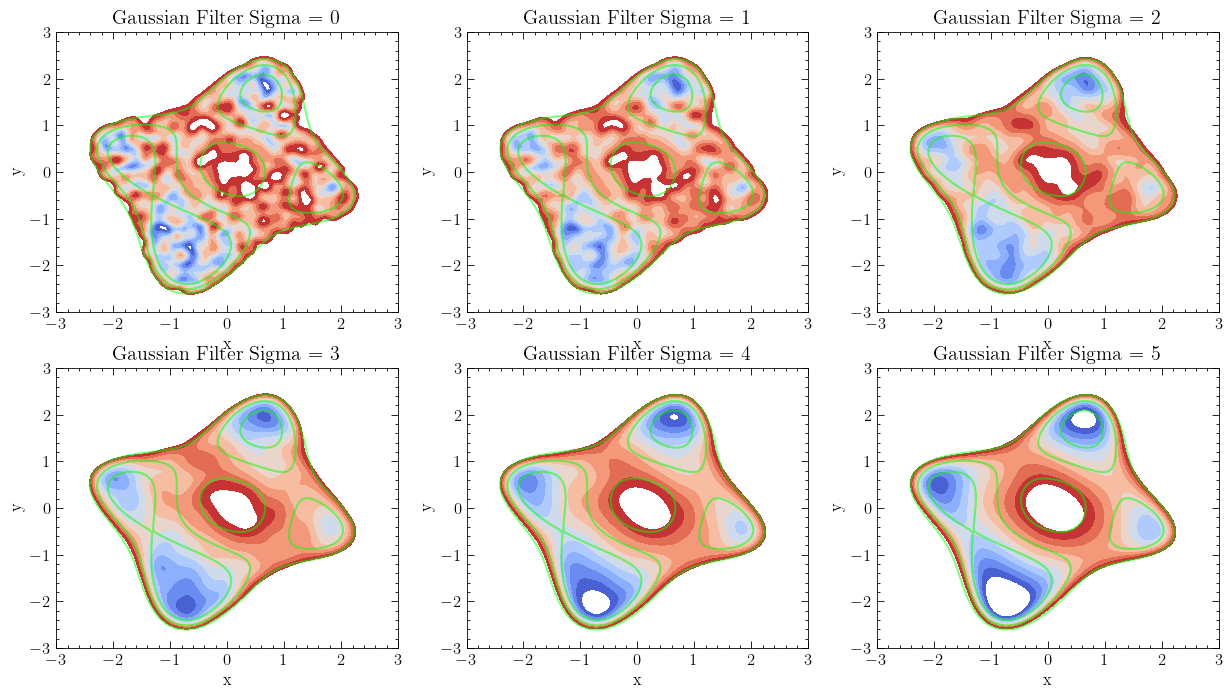

In [30]:
# plot the free energy surface and the filtered free energy surface and the AD and the potential + static bias
from scipy.ndimage import gaussian_filter
gfs = 3

fes = MFI_expl.FES
ad_fes = np.where(pot1 <= 40, np.abs(fes - pot1), 0)
print(f"AAD FES: {np.sum(ad_fes)/(np.count_nonzero(ad_fes)):.4f}")


for _plot_ in [1]:
    
    plt.figure(figsize=(15,8))
    
    for jj in [0, 1, 2, 3, 4, 5]:
        
        fes_filered = gaussian_filter(fes, sigma=jj)
        ad_fes_filtered = np.where(pot1 <= 40, np.abs(fes_filered - pot1), 0)
        print(f"AAD FES_filtered with sigma={jj}: {np.sum(ad_fes_filtered)/(np.count_nonzero(ad_fes)):.4f}")
        
        bias, fx_bias, fy_bias, file_path_dat = lib2.make_external_bias_2D(X, Y, FES=fes, Bias_sf=1, gaus_filter_sigma=jj, FES_cutoff=40, return_array=True)
        plt.subplot(2,3,jj+1)
        plt.contourf(X, Y, pot1+bias, levels=np.linspace(30, 45, 11), cmap='coolwarm'); plt.xlabel("x"); plt.ylabel("y"); plt.title(f"Gaussian Filter Sigma = {jj}")
        plt.contour(X, Y, pot1, levels=np.linspace(20, 40, 3), colors='lime', alpha=0.5)
        
    plt.show()

### 2nd Stage - 1x MetaD simulation

Time taken for MetaD. simulation: 6.1399 sec
Final Error: Aofe = 5.5344, AAD = 2.5457


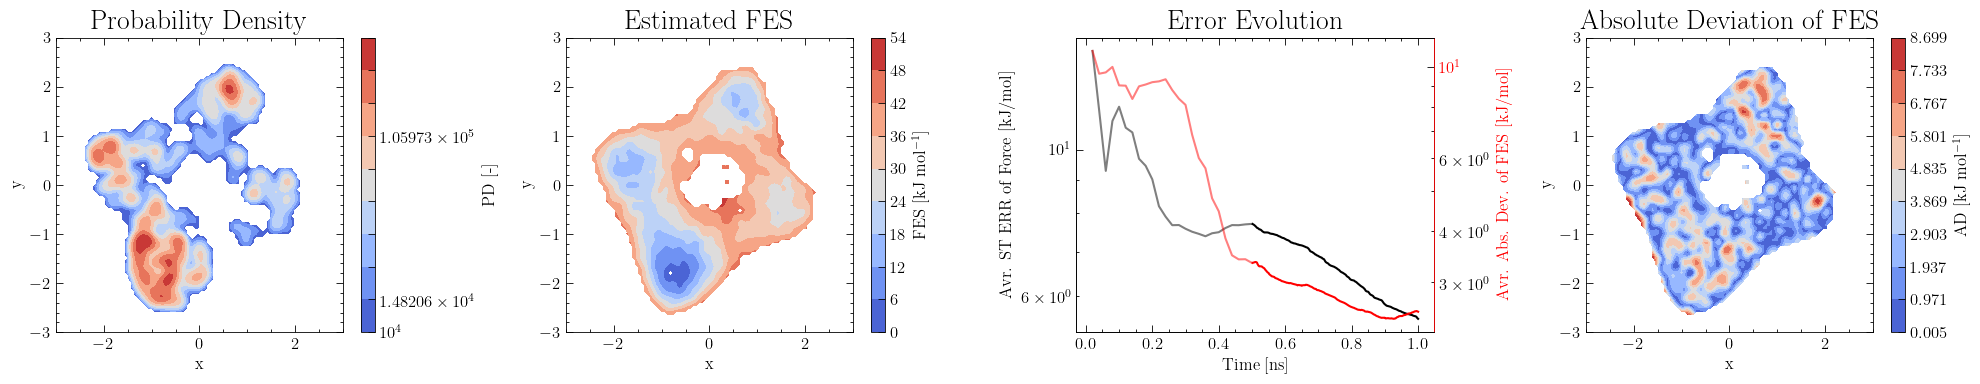

In [50]:
new_params = {**default_params}
new_params.update({"ID":"_metad"})
new_params.update({"simulation_steps":1_350_000, "len_error_list":200, "n_pos":5_000, "record_maps":True})
new_params.update({"metad_height":2, "biasfactor":5})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})

start_metad = time.time()
MFI_metad = MFI_class2D.MFI2D(**new_params)
MFI_metad.make_external_bias(FES=MFI_expl.FES)
# MFI_metad.run_simulation()
MFI_metad.analyse_data()
finish_metad = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad - start_metad:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad.Aofe:.4f}, AAD = {MFI_metad.AAD:.4f}")

MFI_metad.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_metad, aofe_metad, aad_metad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.Avr_Error_info.index("AAD")]
t1x1, aofe1x1, aad1x1 = np.concatenate((t_expl, t_metad)), np.concatenate((aofe_expl, aofe_metad)), np.concatenate((aad_expl, aad_metad))

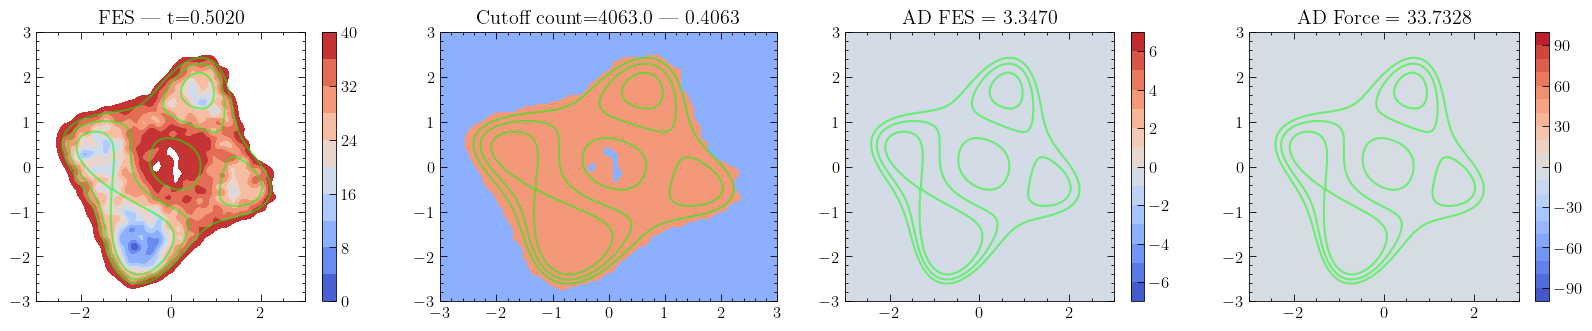

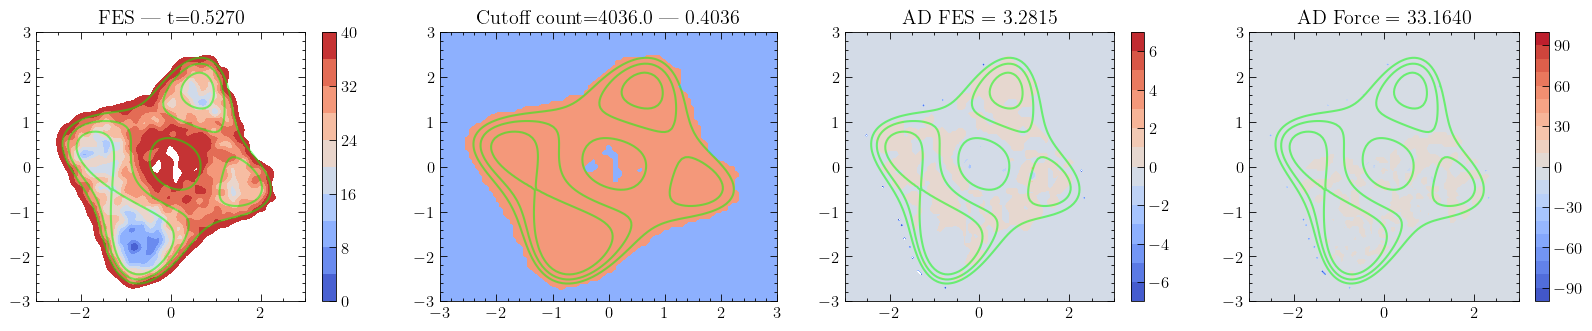

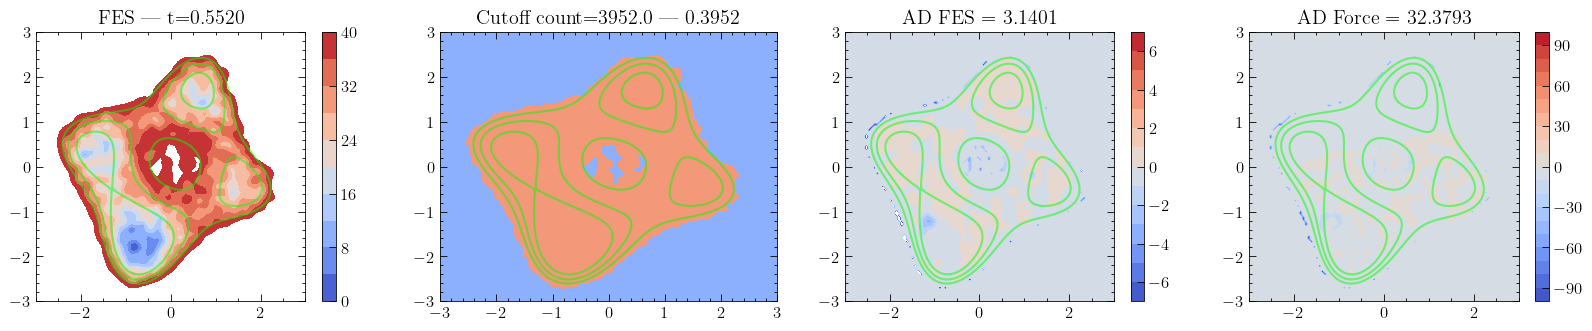

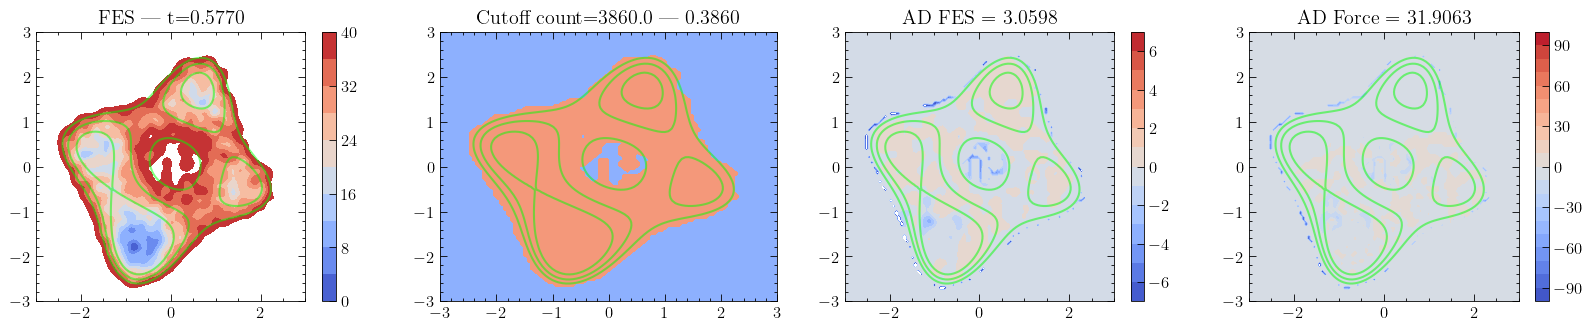

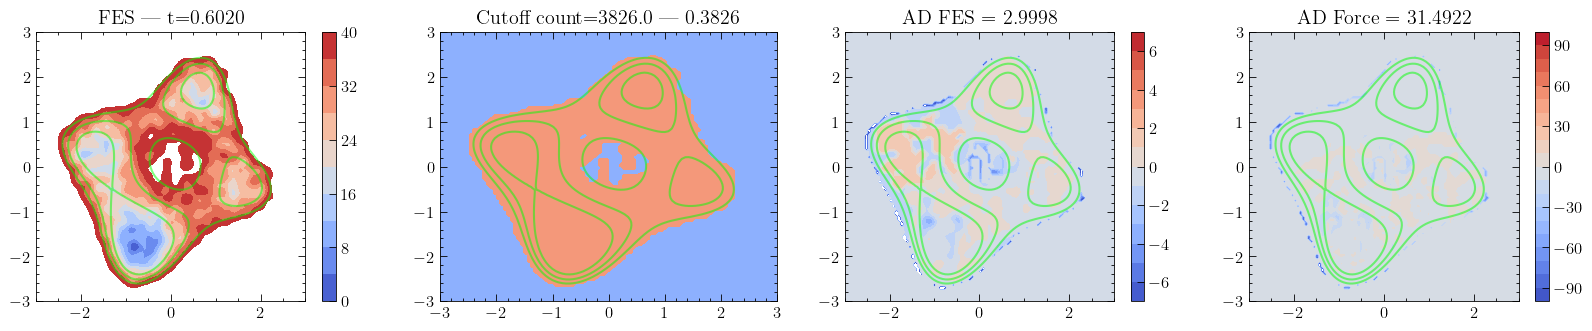

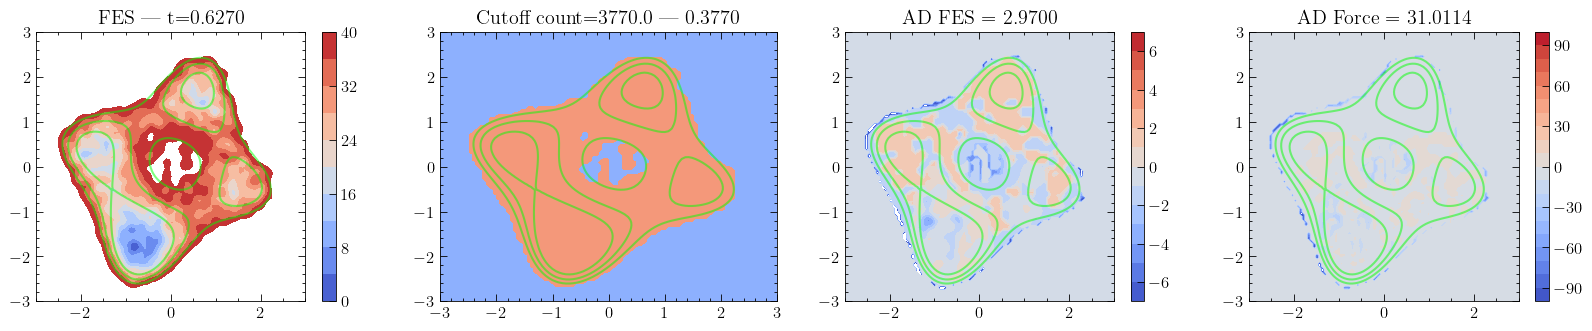

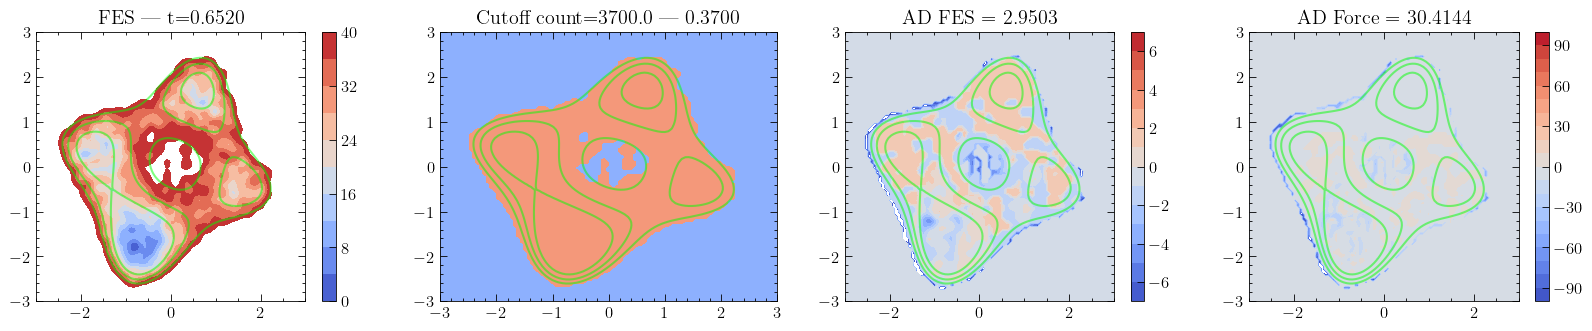

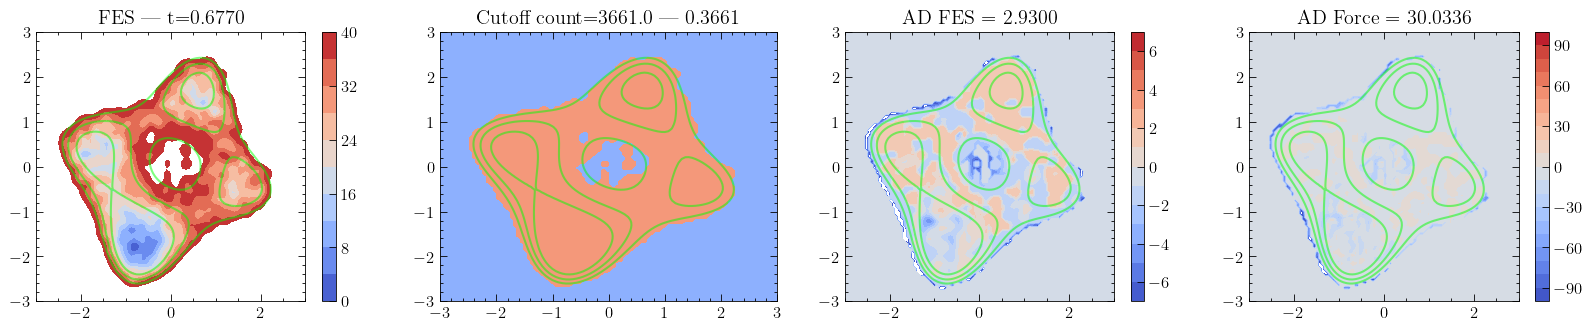

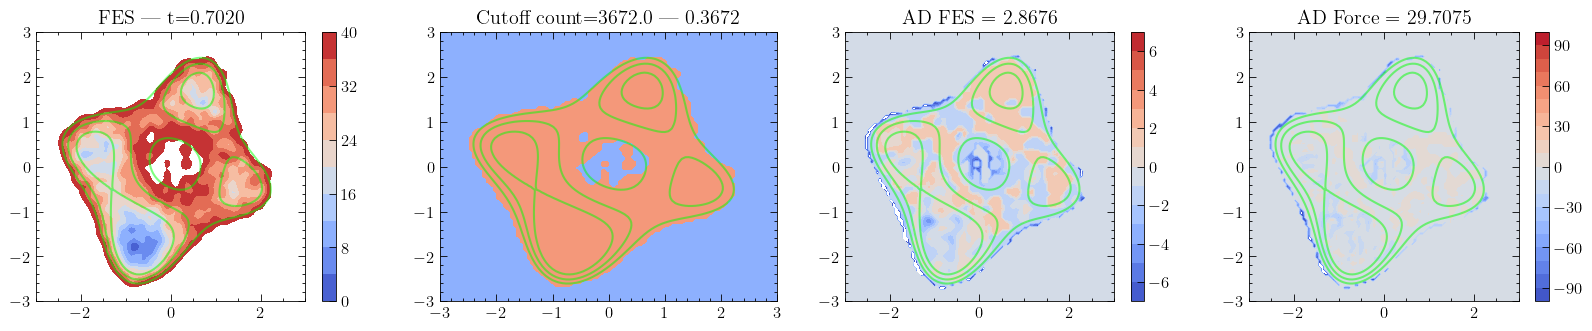

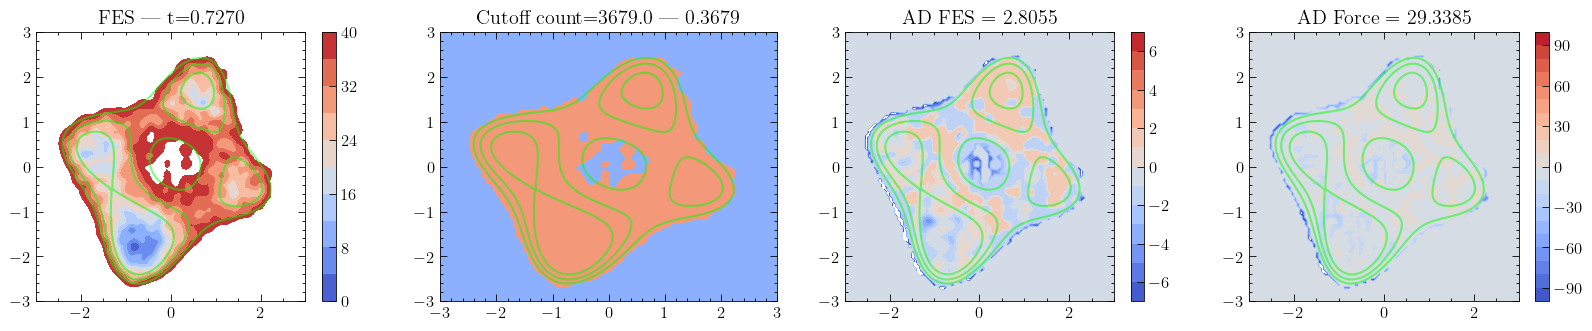

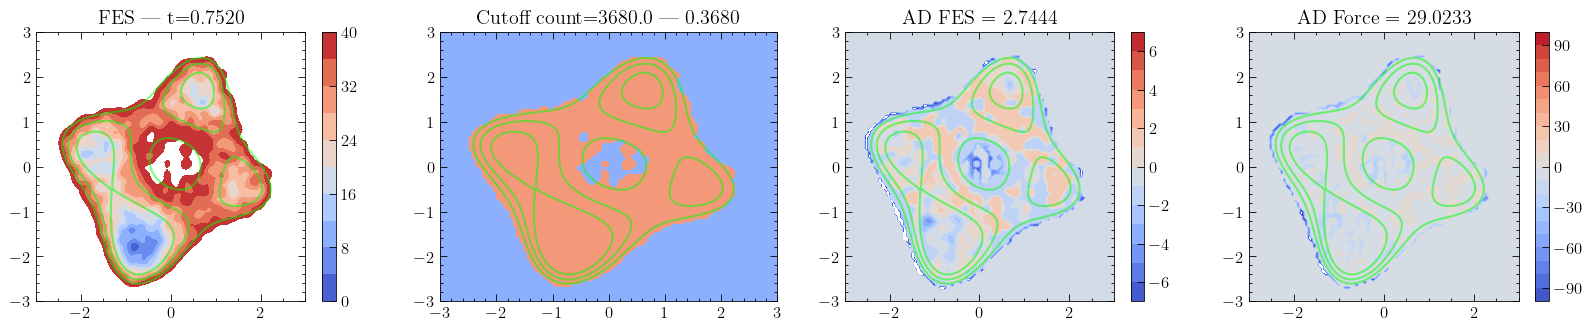

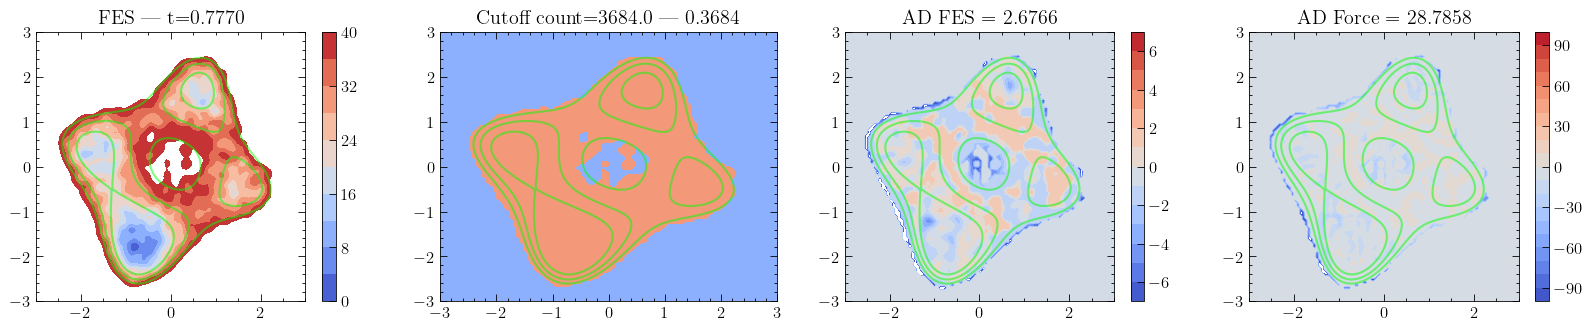

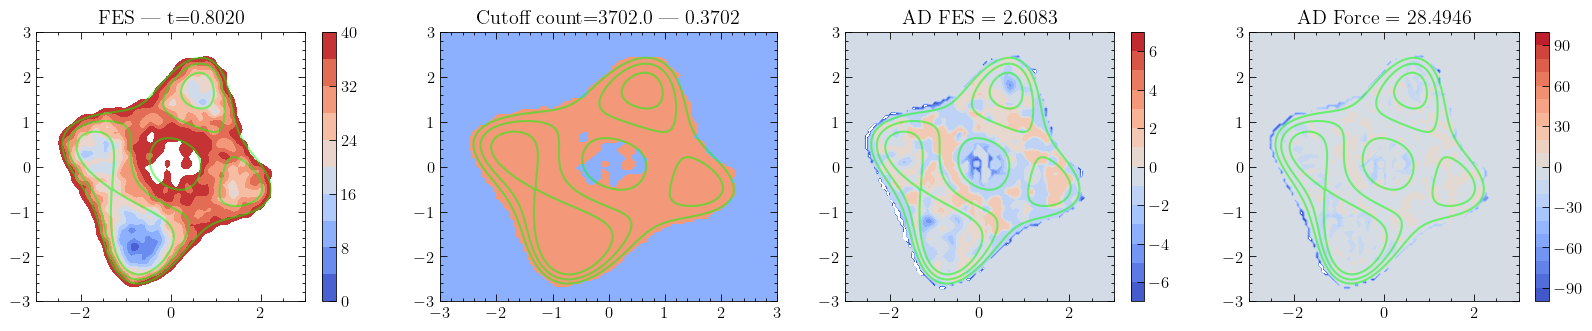

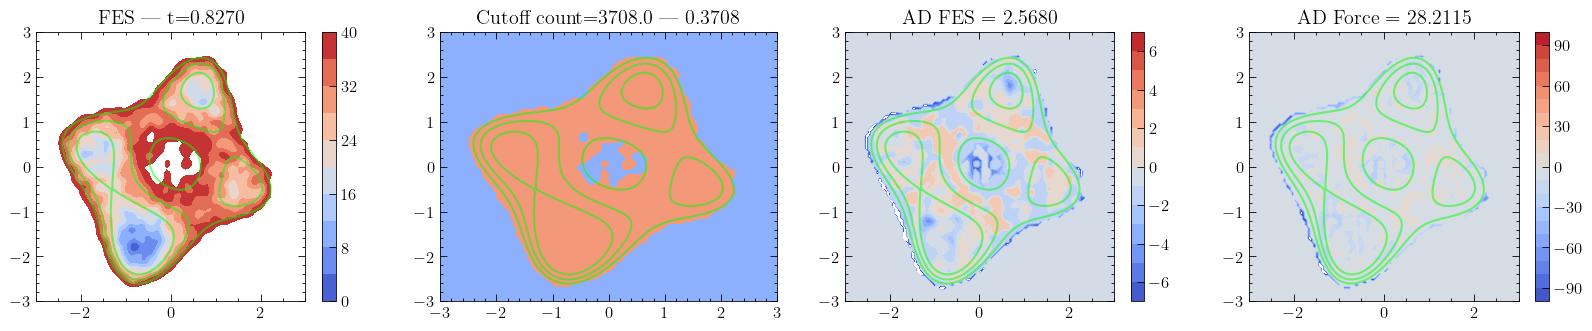

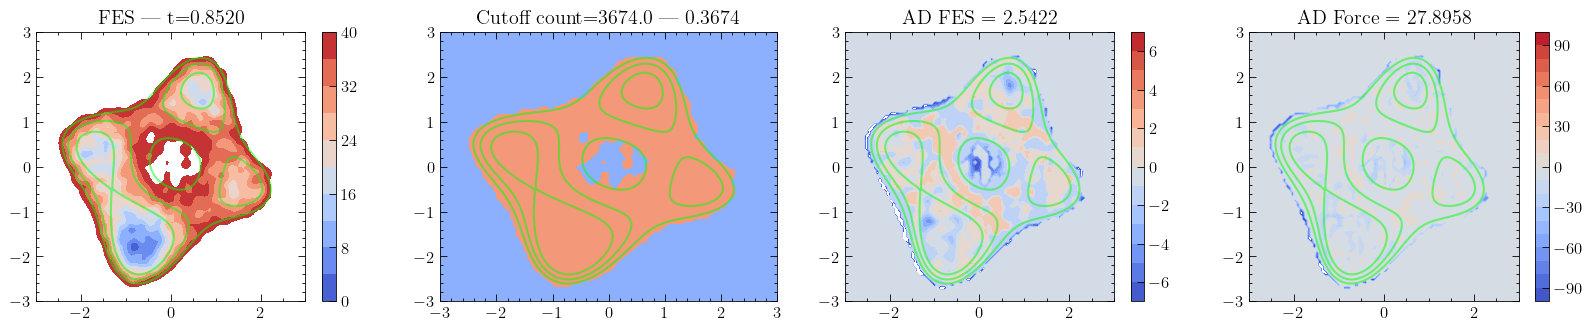

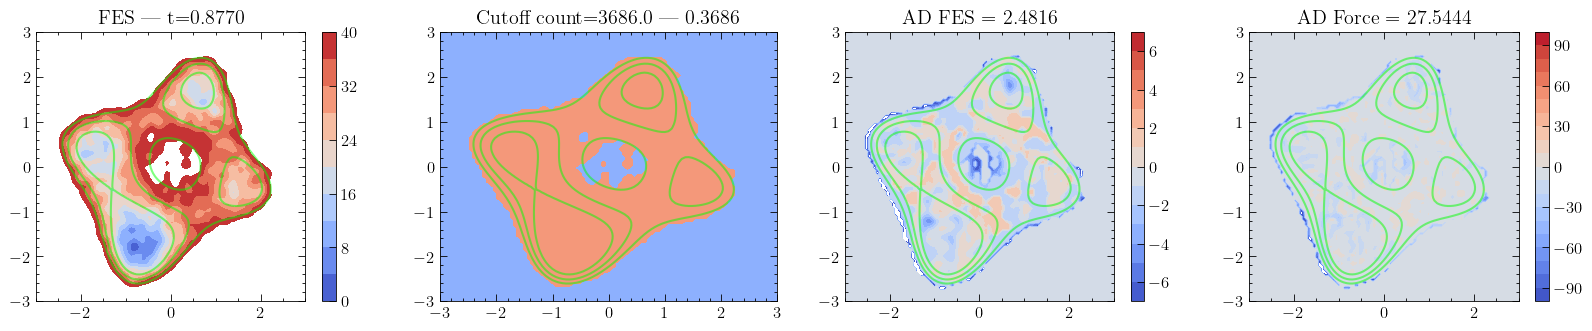

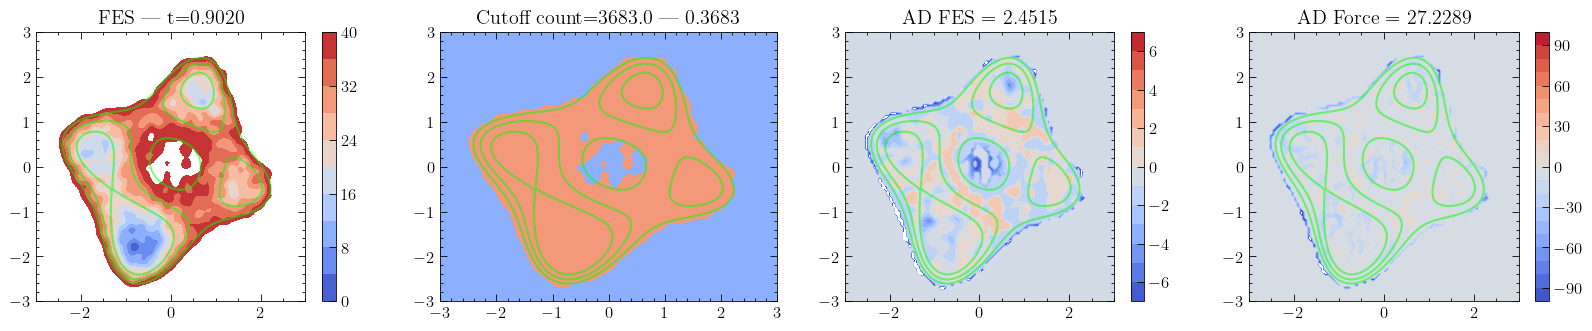

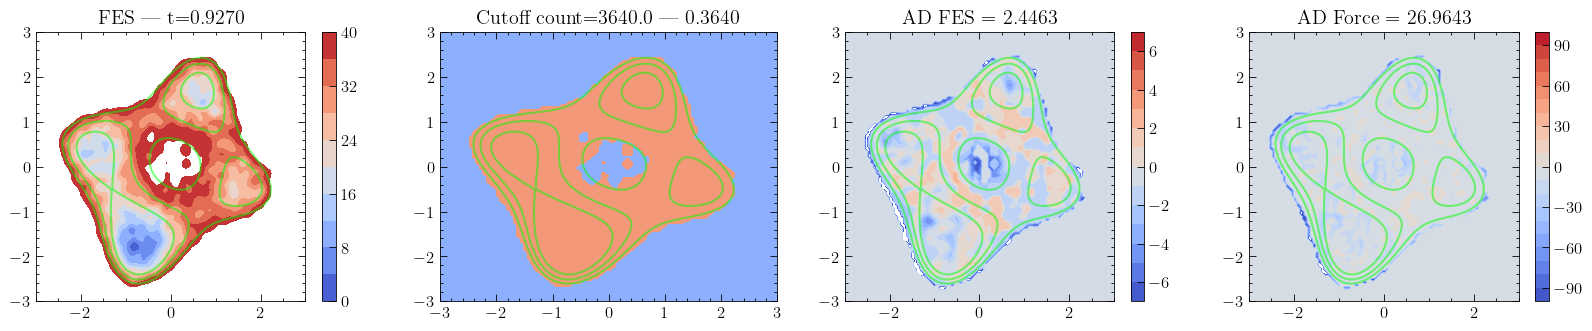

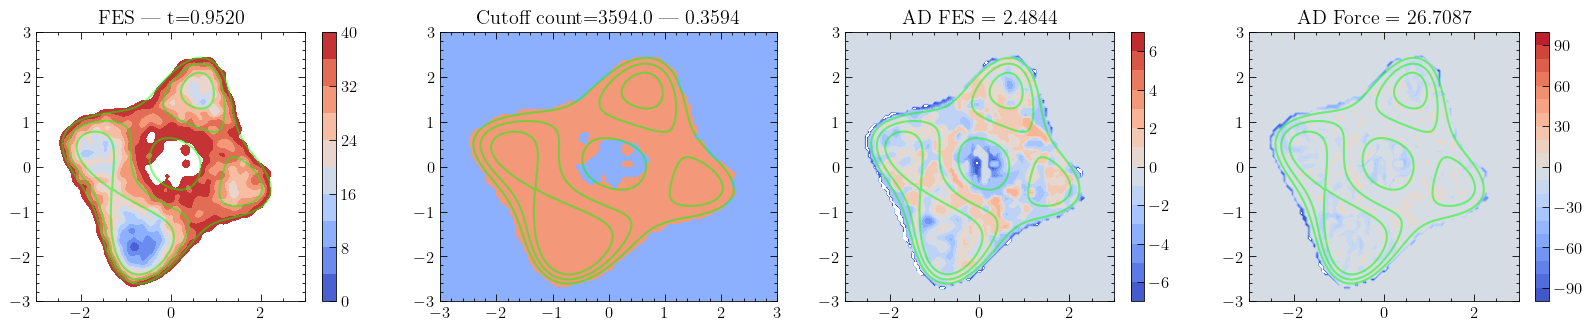

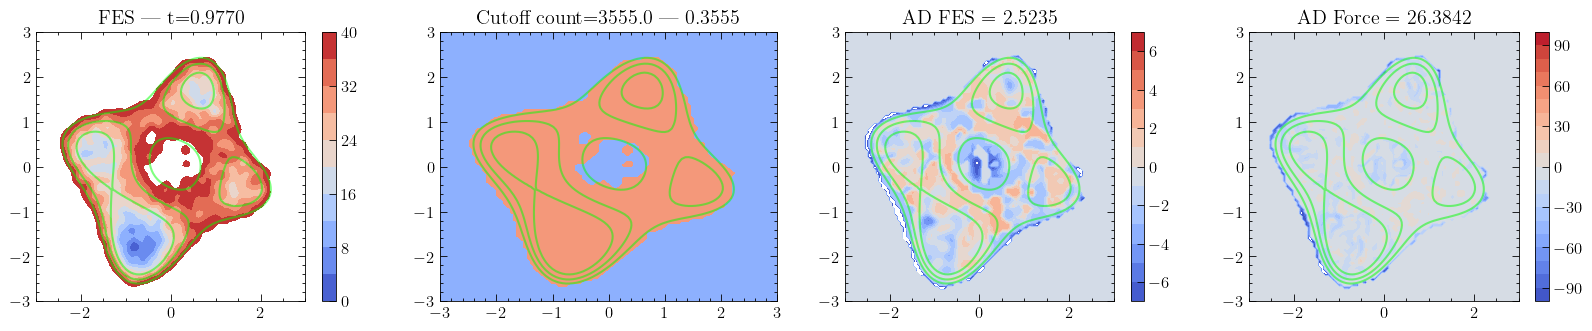

In [55]:
MFI_metad.Maps_list.shape

for jj in range(len(MFI_metad.Maps_list)):

    if jj > 200: break
    if jj % 10 == 0: pass
    else: continue
    plt.figure(figsize=(20, 3.5))
    plt.subplot(1, 4, 1)
    plt.contourf(X, Y, MFI_metad.Maps_list[jj, 0], levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(); plt.title(f"FES | t={MFI_metad.Avr_Error_list[jj, 0]:.4f}")
    plt.contour(X, Y, pot1, levels=np.linspace(20, 40, 3), colors='lime', alpha=0.5)
    plt.subplot(1, 4, 2)
    plt.contourf(X, Y, MFI_metad.Maps_list[jj, 1], levels=np.linspace(0, 1, 3), cmap='coolwarm'); plt.title(f"Cutoff count={np.sum(MFI_metad.Maps_list[jj, 1])} | {MFI_metad.Avr_Error_list[jj, 1]:.4f}")
    plt.contour(X, Y, pot1, levels=np.linspace(20, 40, 3), colors='lime', alpha=0.5)
    plt.subplot(1, 4, 3)
    plt.contourf(X, Y, MFI_metad.Maps_list[jj, 3]-MFI_metad.Maps_list[0, 3], levels=np.linspace(-7, 7, 15), cmap='coolwarm'); plt.title(f"AD FES = {MFI_metad.Avr_Error_list[jj, 3]:.4f}"); plt.colorbar()
    plt.contour(X, Y, pot1, levels=np.linspace(20, 40, 3), colors='lime', alpha=0.5)
    plt.subplot(1, 4, 4)
    plt.contourf(X, Y, MFI_metad.Maps_list[jj, 4]-MFI_metad.Maps_list[0, 4], levels=np.linspace(-100, 100, 21), cmap='coolwarm'); plt.title(f"AD Force = {MFI_metad.Avr_Error_list[jj, 4]:.4f}"); plt.colorbar()
    plt.contour(X, Y, pot1, levels=np.linspace(20, 40, 3), colors='lime', alpha=0.5)
    plt.show()
    

Time taken for MetaD. simulation: 38.8424 sec
Final Error: Aofe = 1.3347, AAD = 0.7666


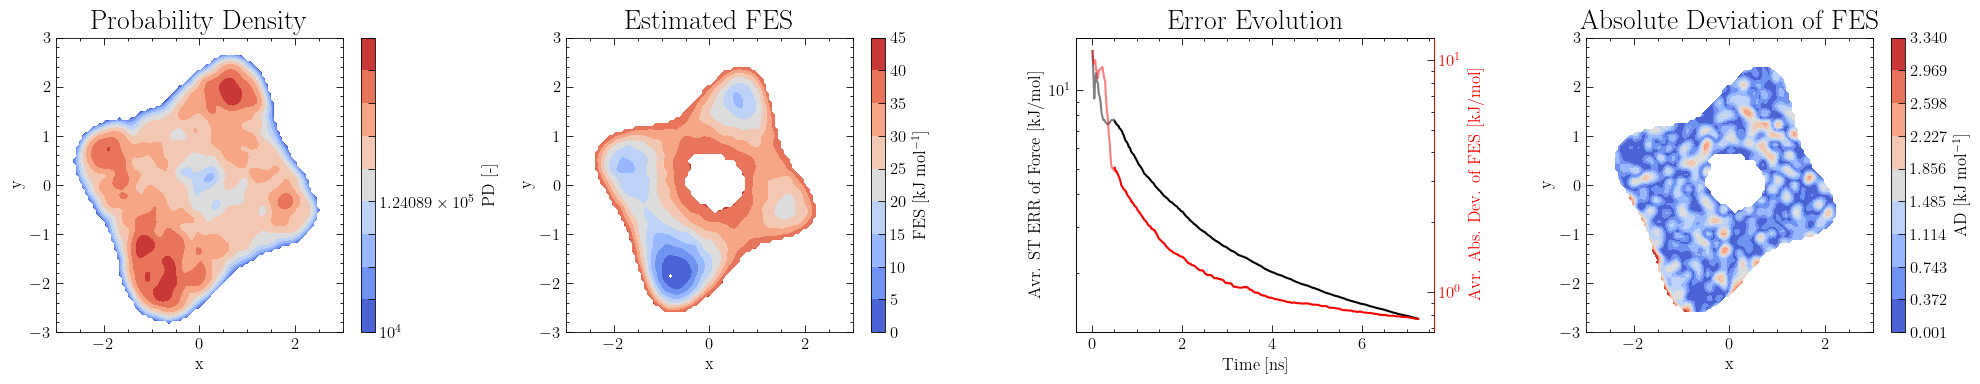

In [17]:
new_params = {**default_params}
gfs = 1
new_params.update({"ID":f"_metad_gf{gfs}"})
new_params.update({"simulation_steps":1_350_000, "len_error_list":475})#, "n_pos":10_000})
new_params.update({"metad_height":2, "biasfactor":5})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})
new_params.update({"gaus_filter_sigma":gfs})

start_metad = time.time()
MFI_metad = MFI_class2D.MFI2D(**new_params)
MFI_metad.make_external_bias(FES=MFI_expl.FES)
MFI_metad.run_simulation()
MFI_metad.analyse_data()
finish_metad = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad - start_metad:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad.Aofe:.4f}, AAD = {MFI_metad.AAD:.4f}")

MFI_metad.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_metad, aofe_metad, aad_metad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.Avr_Error_info.index("AAD")]
t1x1, aofe1x1, aad1x1 = np.concatenate((t_expl, t_metad)), np.concatenate((aofe_expl, aofe_metad)), np.concatenate((aad_expl, aad_metad))

Time taken for MetaD. simulation: 37.9810 sec
Final Error: Aofe = 1.3295, AAD = 0.6956


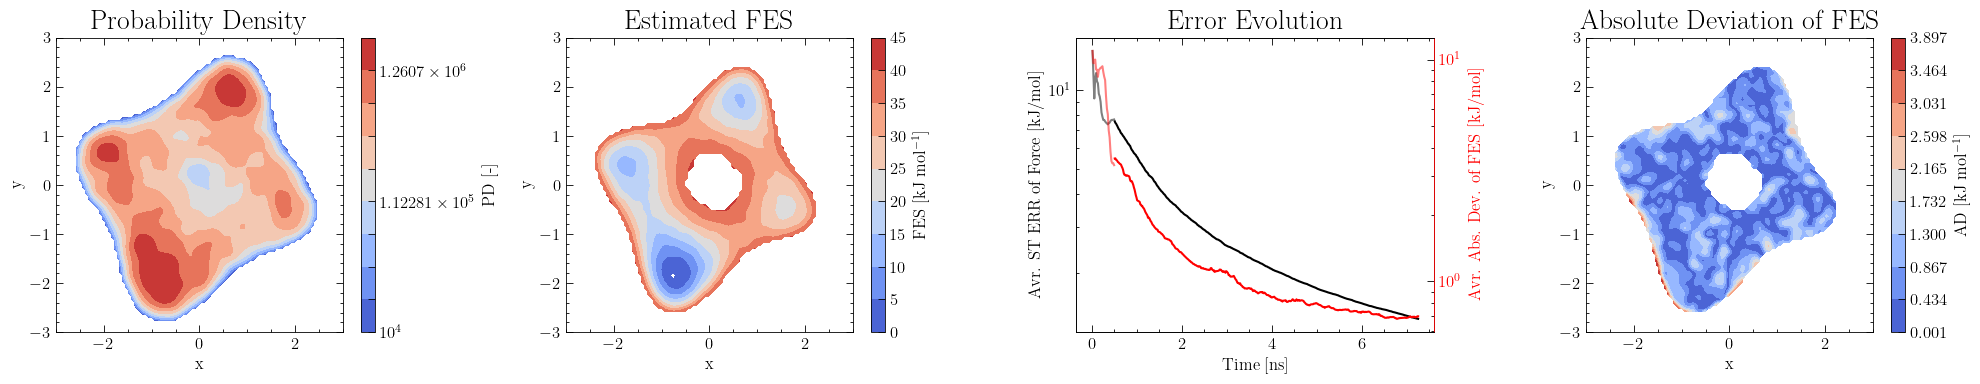

In [18]:
new_params = {**default_params}
gfs = 2
new_params.update({"ID":f"_metad_gf{gfs}"})
new_params.update({"simulation_steps":1_350_000, "len_error_list":475})#, "n_pos":10_000})
new_params.update({"metad_height":2, "biasfactor":5})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})
new_params.update({"gaus_filter_sigma":gfs})

start_metad = time.time()
MFI_metad = MFI_class2D.MFI2D(**new_params)
MFI_metad.make_external_bias(FES=MFI_expl.FES)
MFI_metad.run_simulation()
MFI_metad.analyse_data()
finish_metad = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad - start_metad:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad.Aofe:.4f}, AAD = {MFI_metad.AAD:.4f}")

MFI_metad.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_metad, aofe_metad, aad_metad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.Avr_Error_info.index("AAD")]
t1x1, aofe1x1, aad1x1 = np.concatenate((t_expl, t_metad)), np.concatenate((aofe_expl, aofe_metad)), np.concatenate((aad_expl, aad_metad))

Time taken for MetaD. simulation: 4.7347 sec
Final Error: Aofe = 5.7601, AAD = 3.6875


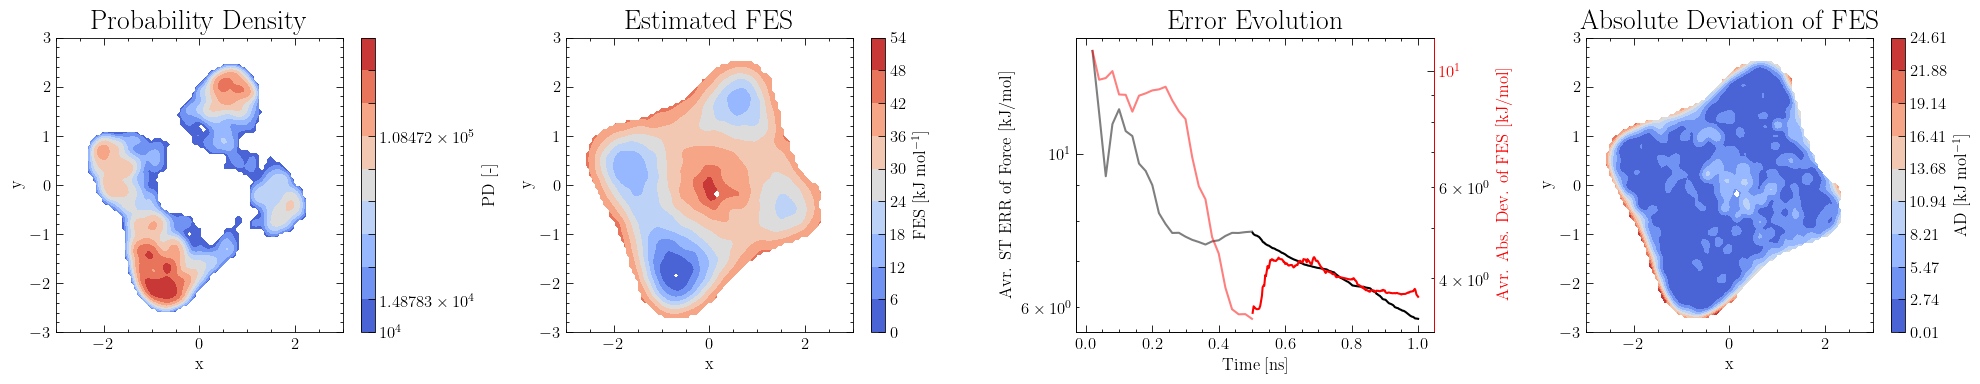

In [37]:
new_params = {**default_params}
gfs = 3
new_params.update({"ID":f"_metad_gf{gfs}"})
new_params.update({"simulation_steps":1_350_000, "len_error_list":200, "n_pos":5_000, "record_maps":True})
new_params.update({"metad_height":2, "biasfactor":5})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})
new_params.update({"gaus_filter_sigma":gfs})

start_metad = time.time()
MFI_metad = MFI_class2D.MFI2D(**new_params)
MFI_metad.make_external_bias(FES=MFI_expl.FES)
# MFI_metad.run_simulation()
MFI_metad.analyse_data()
finish_metad = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad - start_metad:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad.Aofe:.4f}, AAD = {MFI_metad.AAD:.4f}")

MFI_metad.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_metad, aofe_metad, aad_metad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.Avr_Error_info.index("AAD")]
t1x1, aofe1x1, aad1x1 = np.concatenate((t_expl, t_metad)), np.concatenate((aofe_expl, aofe_metad)), np.concatenate((aad_expl, aad_metad))

In [48]:
# MFI_metad.Maps_list.shape

# for jj in range(len(MFI_metad.Maps_list)):

#     if jj > 100: break
#     if jj % 10 == 0: pass
#     else: continue
#     plt.figure(figsize=(20, 3.5))
#     plt.subplot(1, 4, 1)
#     plt.contourf(X, Y, MFI_metad.Maps_list[jj, 0], levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(); plt.title(f"FES | t={MFI_metad.Avr_Error_list[jj, 0]:.4f}")
#     plt.subplot(1, 4, 2)
#     plt.contourf(X, Y, MFI_metad.Maps_list[jj, 1], levels=np.linspace(0, 1, 3), cmap='coolwarm'); plt.title(f"Cutoff count={np.sum(MFI_metad.Maps_list[jj, 1])} | {MFI_metad.Avr_Error_list[jj, 1]:.4f}")
#     plt.subplot(1, 4, 3)
#     plt.contourf(X, Y, MFI_metad.Maps_list[jj, 3]-MFI_metad.Maps_list[0, 3], levels=np.linspace(-5, 5, 21), cmap='coolwarm'); plt.title(f"AD FES = {MFI_metad.Avr_Error_list[jj, 3]:.4f}"); plt.colorbar()
#     plt.subplot(1, 4, 4)
#     plt.contourf(X, Y, MFI_metad.Maps_list[jj, 4]-MFI_metad.Maps_list[0, 4], levels=np.linspace(-100, 100, 21), cmap='coolwarm'); plt.title(f"AD Force = {MFI_metad.Avr_Error_list[jj, 4]:.4f}"); plt.colorbar()
#     plt.show()
    

Time taken for MetaD. simulation: 39.6108 sec
Final Error: Aofe = 1.6291, AAD = 1.0964


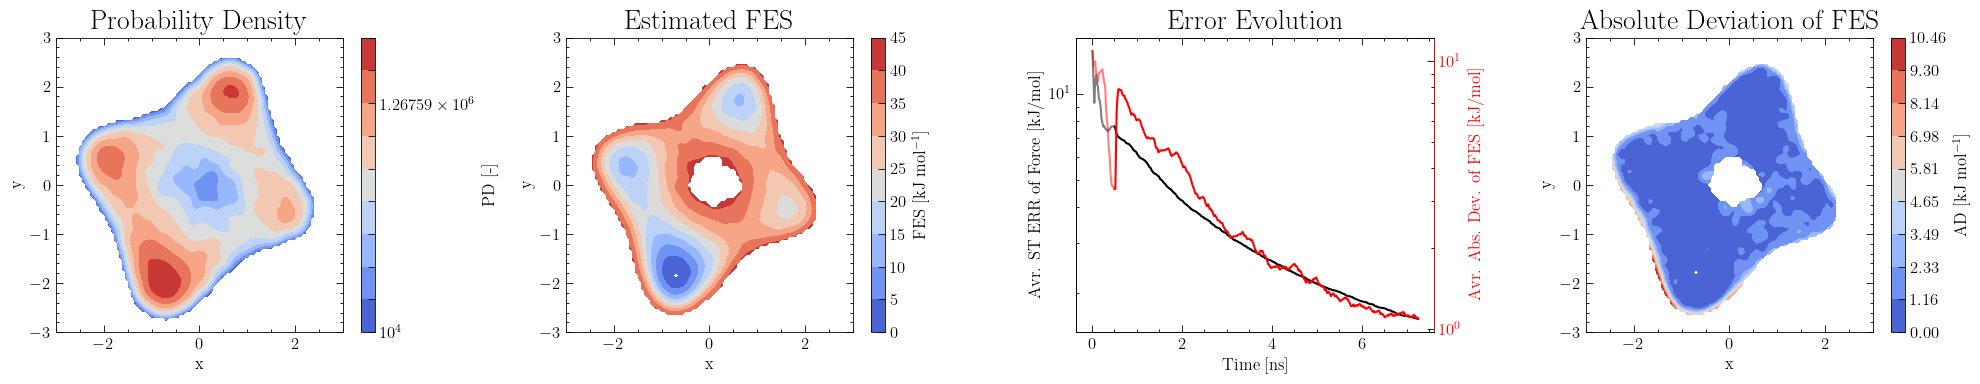

In [20]:
new_params = {**default_params}
gfs = 5
new_params.update({"ID":f"_metad_gf{gfs}"})
new_params.update({"simulation_steps":1_350_000, "len_error_list":475})#, "n_pos":10_000})
new_params.update({"metad_height":2, "biasfactor":5})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})
new_params.update({"gaus_filter_sigma":gfs})

start_metad = time.time()
MFI_metad = MFI_class2D.MFI2D(**new_params)
MFI_metad.make_external_bias(FES=MFI_expl.FES)
MFI_metad.run_simulation()
MFI_metad.analyse_data()
finish_metad = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad - start_metad:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad.Aofe:.4f}, AAD = {MFI_metad.AAD:.4f}")

MFI_metad.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_metad, aofe_metad, aad_metad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.Avr_Error_info.index("AAD")]
t1x1, aofe1x1, aad1x1 = np.concatenate((t_expl, t_metad)), np.concatenate((aofe_expl, aofe_metad)), np.concatenate((aad_expl, aad_metad))

Time taken for MetaD. simulation: 39.1349 sec
Final Error: Aofe = 1.8672, AAD = 1.7372


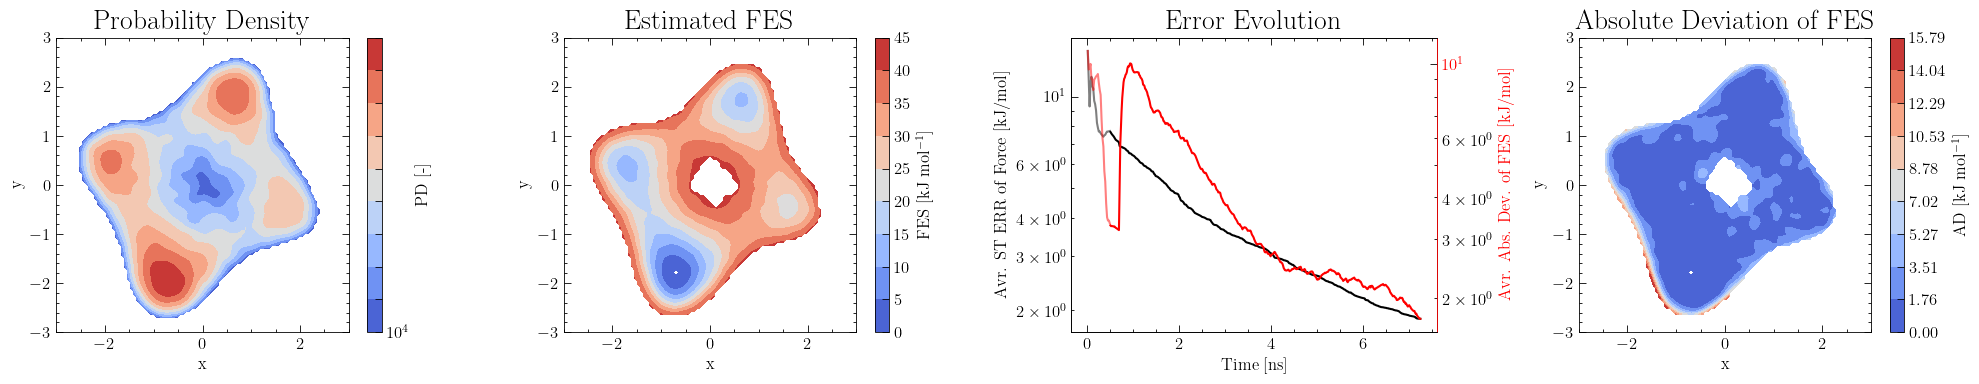

In [21]:
new_params = {**default_params}
gfs = 6
new_params.update({"ID":f"_metad_gf{gfs}"})
new_params.update({"simulation_steps":1_350_000, "len_error_list":475})#, "n_pos":10_000})
new_params.update({"metad_height":2, "biasfactor":5})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})
new_params.update({"gaus_filter_sigma":gfs})

start_metad = time.time()
MFI_metad = MFI_class2D.MFI2D(**new_params)
MFI_metad.make_external_bias(FES=MFI_expl.FES)
MFI_metad.run_simulation()
MFI_metad.analyse_data()
finish_metad = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad - start_metad:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad.Aofe:.4f}, AAD = {MFI_metad.AAD:.4f}")

MFI_metad.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_metad, aofe_metad, aad_metad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.Avr_Error_info.index("AAD")]
t1x1, aofe1x1, aad1x1 = np.concatenate((t_expl, t_metad)), np.concatenate((aofe_expl, aofe_metad)), np.concatenate((aad_expl, aad_metad))

### 2nd Stage - 2x MetaD simulations

In [85]:
os.chdir(path_notebook); reload(MFI_class2D); reload(lib2);

All simulations finished
Time taken for MetaD. simulation: 30.7876 sec
Final Error: Aofe = 0.8478, AAD = 0.3864


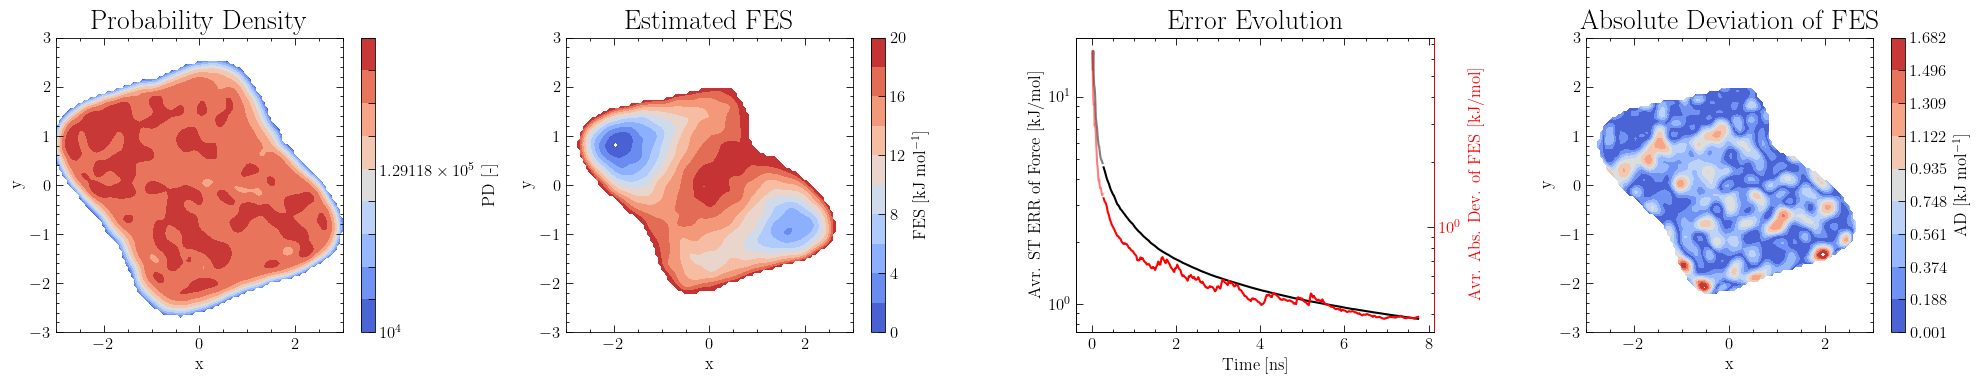

In [86]:
new_params = {**default_params}
new_params.update({"ID":"_metad_x2"})
new_params.update({"simulation_steps":750_000, "len_error_list":300})#, "n_pos":10_000})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})

start_metad_x2 = time.time()
MFI_metad_x2 = MFI_class2D.MFI2D(**new_params)
MFI_metad_x2.make_external_bias(FES=MFI_expl.FES)
mfi_parallel_x2 = MFI_metad_x2.MFI_parallel(parent=MFI_metad_x2, workers=2)
mfi_parallel_x2.run_parallel_sim()
mfi_parallel_x2.analyse_parallel()
mfi_parallel_x2.patch_simulations()
finish_metad_x2 = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad_x2 - start_metad_x2:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad_x2.Aofe:.4f}, AAD = {MFI_metad_x2.AAD:.4f}")

MFI_metad_x2.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_x2, aofe_x2, aad_x2 = MFI_metad_x2.Avr_Error_list[:,0], MFI_metad_x2.Avr_Error_list[:,2], MFI_metad_x2.Avr_Error_list[:, MFI_metad_x2.aad_index]
t1x2, aofe1x2, aad1x2 = np.concatenate((t_expl, t_x2)), np.concatenate((aofe_expl, aofe_x2)), np.concatenate((aad_expl, aad_x2))


### 2nd Stage - 3x MetaD simulations

All simulations finished
Time taken for MetaD. simulation: 18.4508 sec
Final Error: Aofe = 0.7675, AAD = 0.3731


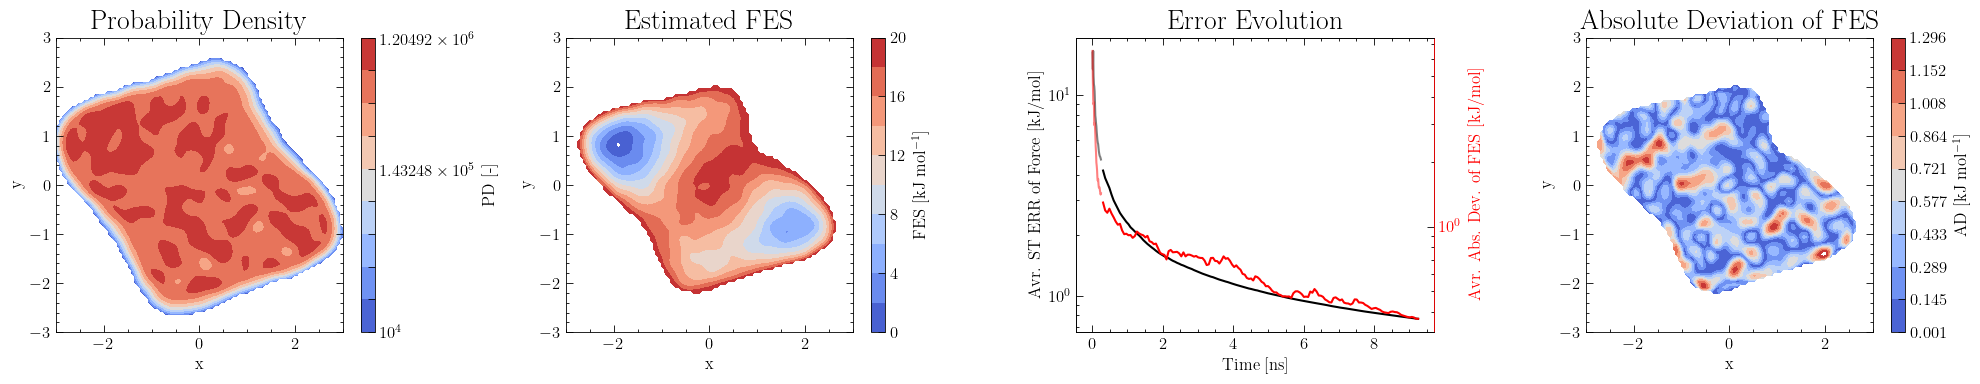

In [90]:
new_params = {**default_params}
new_params.update({"ID":"_metad_x3"})
new_params.update({"simulation_steps":600_000, "len_error_list":150})#, "n_pos":10_000})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})

start_metad_x3 = time.time()
MFI_metad_x3 = MFI_class2D.MFI2D(**new_params)
MFI_metad_x3.make_external_bias(FES=MFI_expl.FES)
mfi_parallel_x3 = MFI_metad_x3.MFI_parallel(parent=MFI_metad_x3, workers=3)
mfi_parallel_x3.run_parallel_sim()
mfi_parallel_x3.analyse_parallel()
mfi_parallel_x3.patch_simulations()
finish_metad_x3 = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad_x3 - start_metad_x3:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad_x3.Aofe:.4f}, AAD = {MFI_metad_x3.AAD:.4f}")

MFI_metad_x3.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_x3, aofe_x3, aad_x3 = MFI_metad_x3.Avr_Error_list[:,0], MFI_metad_x3.Avr_Error_list[:,2], MFI_metad_x3.Avr_Error_list[:, MFI_metad_x3.aad_index]
t1x3, aofe1x3, aad1x3 = np.concatenate((t_expl, t_x3)), np.concatenate((aofe_expl, aofe_x3)), np.concatenate((aad_expl, aad_x3))


### 2nd Stage - 4x MetaD simulations

All simulations finished
Time taken for MetaD. simulation: 18.4508 sec
Final Error: Aofe = 0.7239, AAD = 0.5129


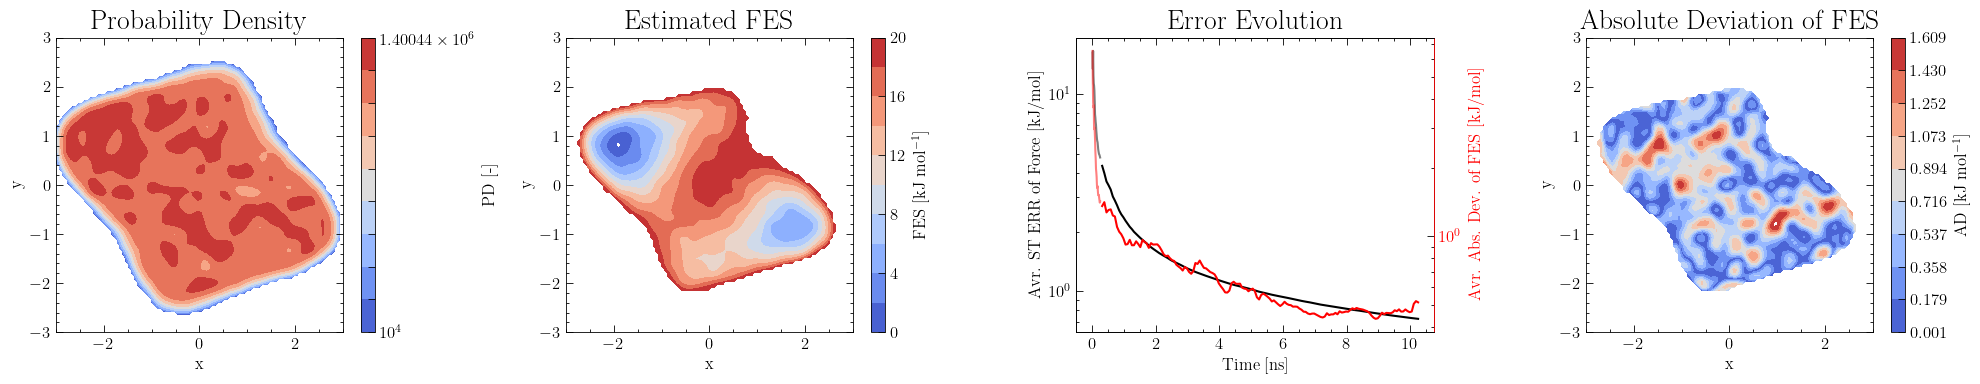

In [91]:
new_params = {**default_params}
new_params.update({"ID":"_metad_x4"})
new_params.update({"simulation_steps":500_000, "len_error_list":150})#, "n_pos":10_000})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})

start_metad_x4 = time.time()
MFI_metad_x4 = MFI_class2D.MFI2D(**new_params)
MFI_metad_x4.make_external_bias(FES=MFI_expl.FES)
mfi_parallel_x4 = MFI_metad_x4.MFI_parallel(parent=MFI_metad_x4, workers=4)
mfi_parallel_x4.run_parallel_sim()
mfi_parallel_x4.analyse_parallel()
mfi_parallel_x4.patch_simulations()
finish_metad_x4 = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad_x3 - start_metad_x3:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad_x4.Aofe:.4f}, AAD = {MFI_metad_x4.AAD:.4f}")

MFI_metad_x4.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_x4, aofe_x4, aad_x4 = MFI_metad_x4.Avr_Error_list[:,0], MFI_metad_x4.Avr_Error_list[:,2], MFI_metad_x4.Avr_Error_list[:, MFI_metad_x4.aad_index]
t1x4, aofe1x4, aad1x4 = np.concatenate((t_expl, t_x4)), np.concatenate((aofe_expl, aofe_x4)), np.concatenate((aad_expl, aad_x4))


### Test with X in parallel

In [51]:
new_params = {**default_params}
new_params.update({"ID":"_metad_xtest"})
new_params.update({"simulation_steps":500_000, "len_error_list":150})#, "n_pos":10_000})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})

MFI_metad_xtest = MFI_class2D.MFI2D(**new_params)
# MFI_metad_xtest.make_external_bias(FES=MFI_expl.FES)
mfi_parallel_xtest = MFI_metad_xtest.MFI_parallel(parent=MFI_metad_xtest, workers=10)
start_metad_xtest = time.time()
mfi_parallel_xtest.run_parallel_sim()
finish_metad_xtest = time.time()
# mfi_parallel_xtest.analyse_parallel()
# mfi_parallel_xtest.patch_simulations()

print(f"Time taken for MetaD. simulation: {finish_metad_xtest - start_metad_xtest:.4f} sec")
# print(F"Final Error: Aofe = {MFI_metad_x4.Aofe:.4f}, AAD = {MFI_metad_x4.AAD:.4f}")

# MFI_metad_x4.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# # MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# t_x4, aofe_x4, aad_x4 = MFI_metad_x4.Avr_Error_list[:,0], MFI_metad_x4.Avr_Error_list[:,2], MFI_metad_x4.Avr_Error_list[:, MFI_metad_x4.aad_index]
# t1x4, aofe1x4, aad1x4 = np.concatenate((t_expl, t_x4)), np.concatenate((aofe_expl, aofe_x4)), np.concatenate((aad_expl, aad_x4))


All simulations finished
Time taken for MetaD. simulation: 12.2134 sec


### Compare Convergence of Simulations

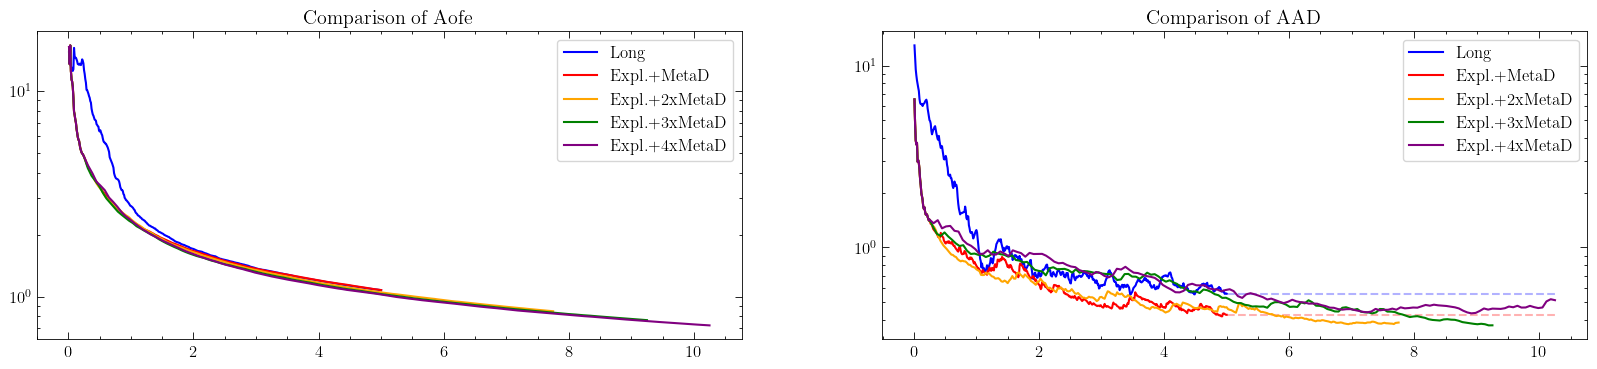

In [94]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
plt.plot(t_long, aofe_long, label="Long", color="blue")
plt.plot(t1x1, aofe1x1, label="Expl.+MetaD", color="red")
plt.plot(t1x2, aofe1x2, label="Expl.+2xMetaD", color="orange")
plt.plot(t1x3, aofe1x3, label="Expl.+3xMetaD", color="green")
plt.plot(t1x4, aofe1x4, label="Expl.+4xMetaD", color="purple")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,2,2)
plt.plot(t_long, aad_long, label="Long", color="blue"); plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
plt.plot(t1x1, aad1x1, label="Expl.+MetaD", color="red"); plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(t1x2, aad1x2, label="Expl.+2xMetaD", color="orange")
plt.plot(t1x3, aad1x3, label="Expl.+3xMetaD", color="green")
plt.plot(t1x4, aad1x4, label="Expl.+4xMetaD", color="purple")
plt.legend(); plt.yscale("log"); plt.title("Comparison of AAD"); plt.show()
